### Data Science Case Study Options 

Please select and complete one of the following case studies. We are looking for you to show off your  machine learning and coding skills using Python or R. You are not required to use AWS in your solution,  but you are welcome to spin up an EC2 instance if you would like to. If you use any AWS services please  remember to terminate them after you complete the exercise. 

Please Note: 
- Do not post solution on GitHub or any other online public site 
- Submit a work sample that is comprehensive with respect to your thought process, code, findings,  and recommendations (ie a notebook with annotations). You may submit other documents if you wish. 

Please send the completed work sample at least 1 days prior to the virtual interview. On the day of the  interview you will need access to a laptop/desktop as you will be sharing your screen and going through  the work sample with the interviewer. 
Please send a document displaying your code, annotations, and thought process in a PDF to  kdalenbe@amazon.com and CC your recruiter at least 24 hours prior to your interview. 

## Option 2: Geological Image Similarity 

BACKGROUND 
A geology research company wants to create a tool for identifying interesting patterns in their imagery  data. This tool will possess a search capability whereby an analyst provides an image of interest and is  presented with other images which are similar to it.

GOAL 
Your task is to create the machine learning component for this image similarity application. The machine  learning model should return the top K images that are most similar to this image based on a single  image input.

In [1]:
import os 
from PIL import Image, ImageOps
import pandas as pd
import pathlib
import time
import numpy as np

from MulticoreTSNE import MulticoreTSNE as TSNE

import matplotlib.pyplot as plt
from matplotlib import offsetbox
%matplotlib inline

In [2]:
cwd_path = os.getcwd()
print('Project Folder:')
print(cwd_path)

Project Folder:
/home/david/Documents/projects/aws_geo_sim


In [3]:
data_path = os.path.join(cwd_path,'data','geological_similarity')
try:
    if os.path.isdir(data_path)==True:
        print('(Success) Data Path:')
        print(data_path)
    else:
        raise FileNotFoundError
except FileNotFoundError:
    print('(ERROR) Extracted data folder is not found at:')
    print(data_path)

(Success) Data Path:
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity


In [4]:
all_file_paths = []

print('Data Folders:')
for root, dirs, files in os.walk(data_path):
    for name in dirs:
        print(os.path.join(root, name))
    for name in files:
        all_file_paths.append(os.path.join(root, name))

#all_files = [element for sublist in all_file_paths for element in sublist]
print('Number of Image Files:')
print(len(all_file_paths))

Data Folders:
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/schist
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/quartzite
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/andesite
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/rhyolite
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/gneiss
/home/david/Documents/projects/aws_geo_sim/data/geological_similarity/marble
Number of Image Files:
29998


In [5]:
# Using PIL for speed vs OpenCV

def get_metadata_single(img_path):
    class_label = pathlib.PurePath(img_path).parent.name
    img = Image.open(img_path)
    width, height = img.size
    color_space = img.mode
    colors = len(img.getbands())

    # Add image file name
    dic = {'image_path': img_path,
            'class': class_label,
            'width': width,
            'height': height,
            'color': color_space,
            'channels': colors}

    return dic

In [6]:
list_of_dics = []
for file_path in all_file_paths:
    list_of_dics.append(get_metadata_single(file_path))

imgs_df = pd.DataFrame.from_dict(list_of_dics)
imgs_df

,image_path,class,width,height,color,channels
0,/home/david/Documents/projects/aws_geo_sim/dat...,schist,28,28,RGB,3
1,/home/david/Documents/projects/aws_geo_sim/dat...,schist,28,28,RGB,3
2,/home/david/Documents/projects/aws_geo_sim/dat...,schist,28,28,RGB,3
3,/home/david/Documents/projects/aws_geo_sim/dat...,schist,28,28,RGB,3
4,/home/david/Documents/projects/aws_geo_sim/dat...,schist,28,28,RGB,3
...,...,...,...,...,...,...
29993,/home/david/Documents/projects/aws_geo_sim/dat...,marble,28,28,RGB,3
29994,/home/david/Documents/projects/aws_geo_sim/dat...,marble,28,28,RGB,3
29995,/home/david/Documents/projects/aws_geo_sim/dat...,marble,28,28,RGB,3
29996,/home/david/Documents/projects/aws_geo_sim/dat...,marble,28,28,RGB,3


In [7]:
type_counts = imgs_df['class'].value_counts()
type_counts = dict(type_counts)
print(type_counts)

imgs_df['class'].value_counts()
# Wow, talk about a toy dataset...
# I've never seen a dataset so well balanced...

{'schist': 5000, 'quartzite': 5000, 'andesite': 5000, 'rhyolite': 5000, 'gneiss': 5000, 'marble': 4998}


schist       5000
quartzite    5000
andesite     5000
rhyolite     5000
gneiss       5000
marble       4998
Name: class, dtype: int64

In [8]:
def plot_embeddings(X, pixels, title=None):
    
    # Normalize embedding values
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)   

    # Plot all the embeddings
    plt.figure()
    plt.figure(figsize=(15,15))
    ax = plt.subplot(111)
    plt.scatter(X[:, 0], X[:, 1], marker='.')
    plt.xticks([]) 
    plt.yticks([])

    # Show thumbnails
    shown_images = np.array([[1., 1.]])
    for i in range(X.shape[0]):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            continue # don’t show points that are too close
        shown_images = np.r_[shown_images, [X[i]]]

        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(pixels[i,:,:,0:3] / 255), X[i])
        ax.add_artist(imagebox)

https://en.wikipedia.org/wiki/HSL_and_HSV

Pixel arrays created for: schist
TSNE embeddings created for: schist


/home/david/miniforge3/envs/aws_geo_sim/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/david/miniforge3/envs/aws_geo_sim/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


<Figure size 432x288 with 0 Axes>

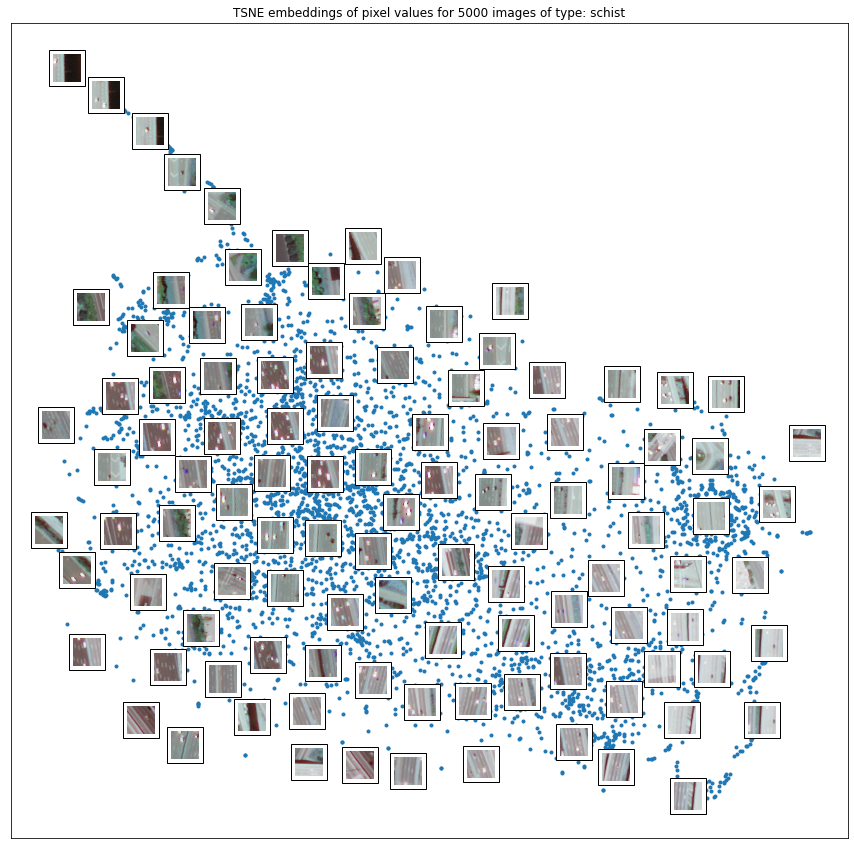

Pixel arrays created for: quartzite
TSNE embeddings created for: quartzite


<Figure size 432x288 with 0 Axes>

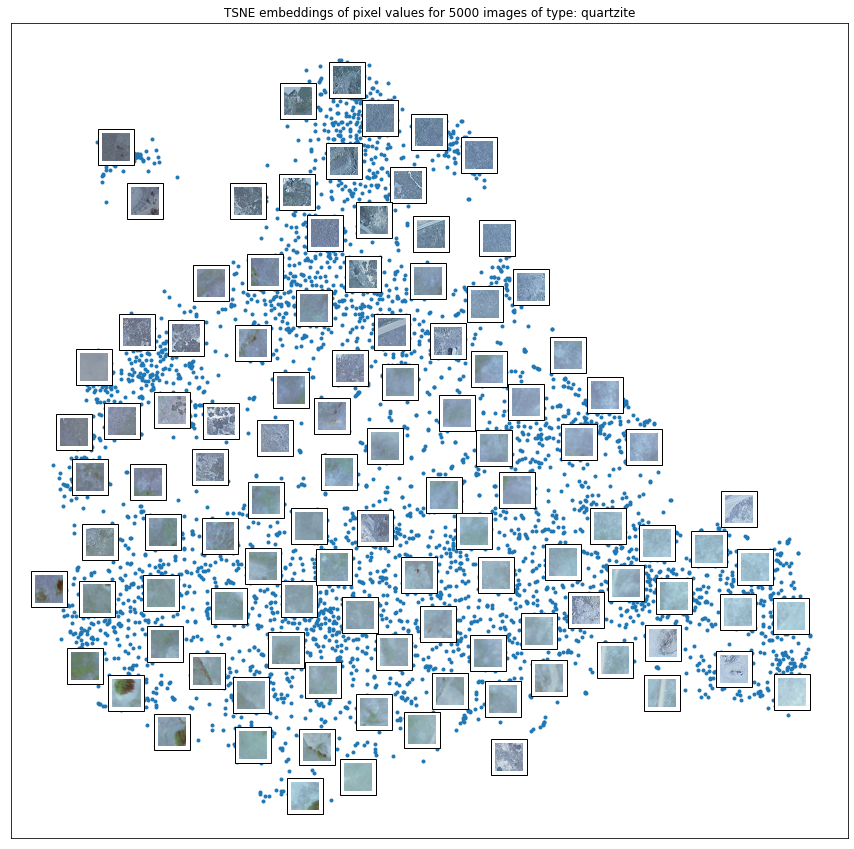

Pixel arrays created for: andesite
TSNE embeddings created for: andesite


<Figure size 432x288 with 0 Axes>

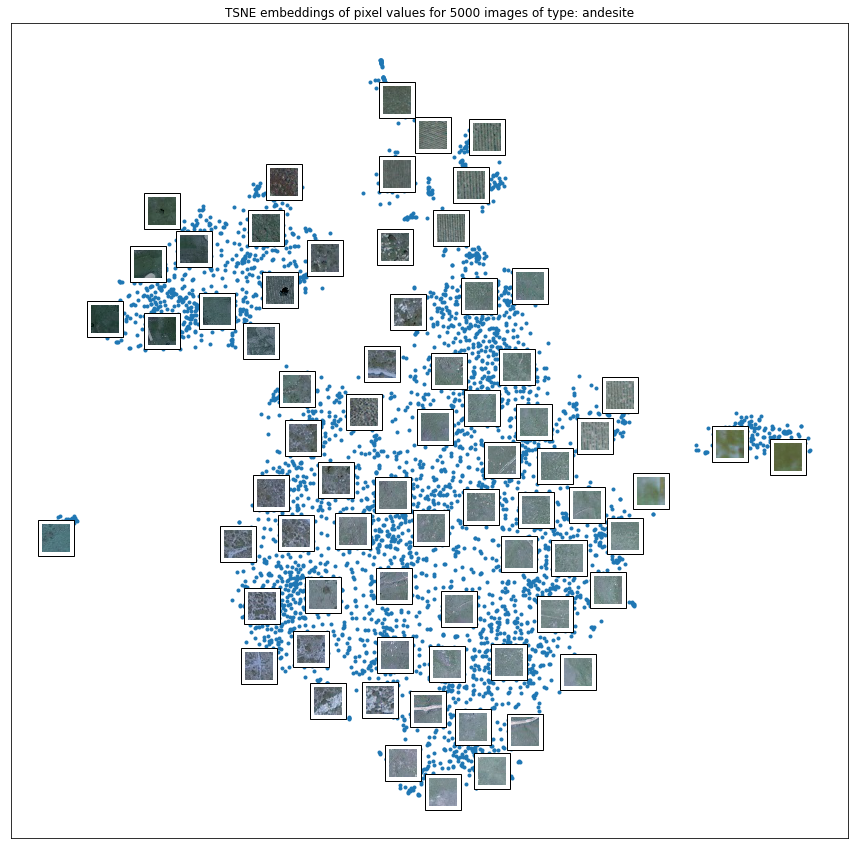

Pixel arrays created for: rhyolite
TSNE embeddings created for: rhyolite


<Figure size 432x288 with 0 Axes>

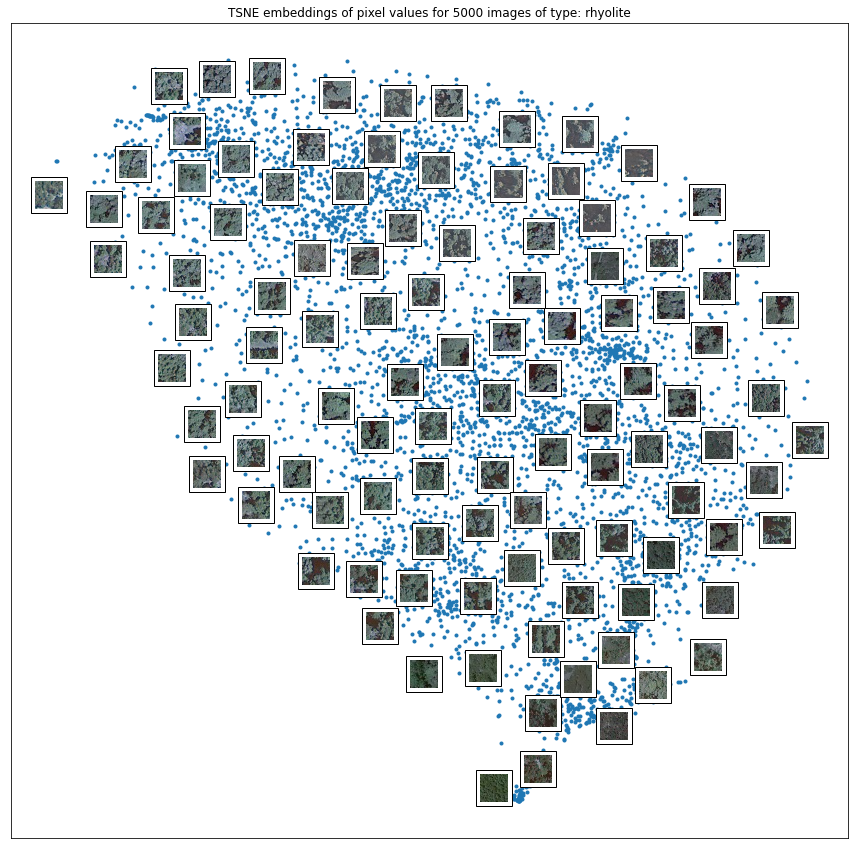

Pixel arrays created for: gneiss
TSNE embeddings created for: gneiss


<Figure size 432x288 with 0 Axes>

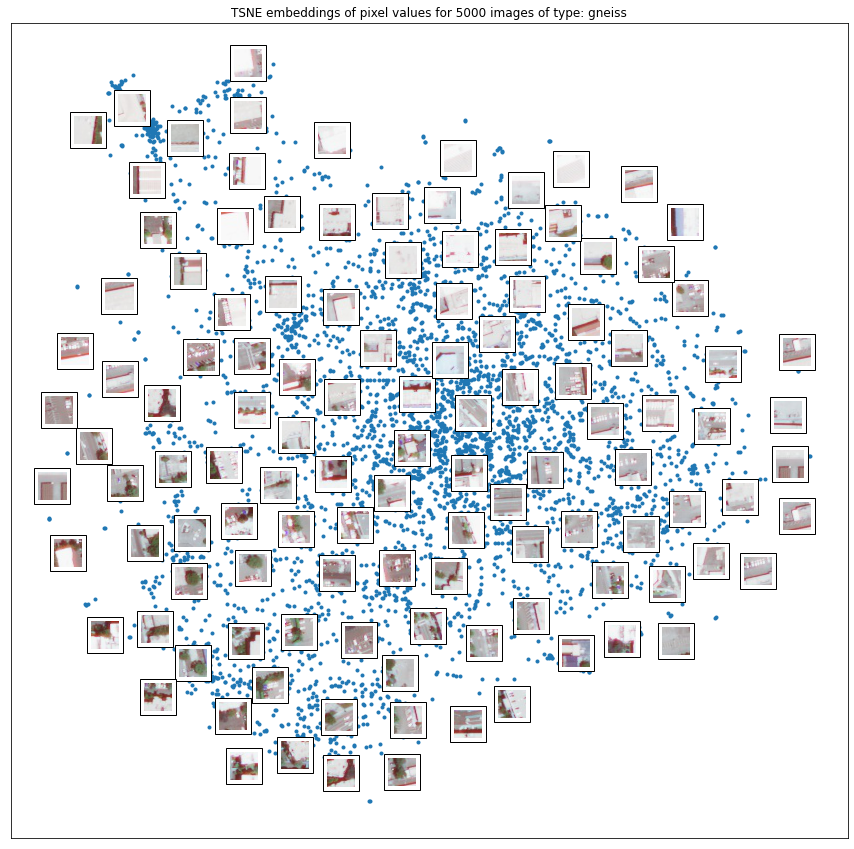

Pixel arrays created for: marble
TSNE embeddings created for: marble


<Figure size 432x288 with 0 Axes>

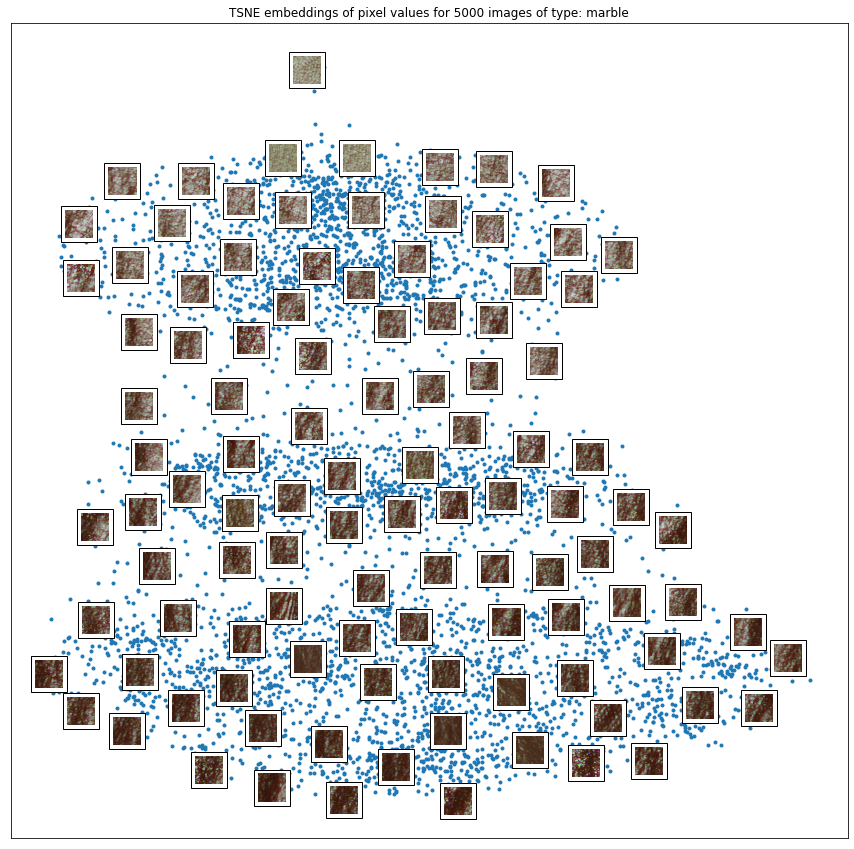

In [9]:
n_colors = 3

for class_type, img_count in type_counts.items():
    rgb_data = np.zeros((img_count,28,28,n_colors))
    hsv_data = np.zeros((img_count,28,28,n_colors))

    for i, img_path in enumerate(imgs_df[imgs_df['class']==class_type]['image_path']):
        img = Image.open(img_path)
        rgb_data[i,:,:,0:3] = np.array(img)
        img = img.convert('HSV') # alternate color space
        hsv_data[i,:,:,0:3] = np.array(img)
        #pixel_data[i,:,:,3] = np.array(ImageOps.grayscale(img))
    print('Pixel arrays created for:',class_type)

    flat_data = np.reshape(hsv_data, (img_count,28*28*n_colors))
    embeddings = TSNE(n_jobs=8).fit_transform(flat_data)
    print('TSNE embeddings created for:',class_type)
    
    plot_embeddings(embeddings,rgb_data)
    plt.title("TSNE embeddings of pixel values for 5000 images of type: "+class_type)
    plt.show()